## Generate Historical CMIP Forcing data


In [9]:


# Ignore user warnings :)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Required dependencies
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print
import xarray as xr
import shutil
import matplotlib.pyplot as plt

import ewatercycle
import ewatercycle.forcing



In [10]:
# The name of the shapefile
shape_file_name = "AralSeaBasin"  # river: Bedford Ouse at Roxton, England

# The path to the shapefiles
shapefile_path =  Path('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/AralSea_Basin')/ f"{shape_file_name}.shp"  # check this directory yourself!

# The time-window of the experiment
experiment_start_date = "1955-01-01T00:00:00Z"
experiment_end_date = "1970-12-31T00:00:00Z"

# The path save directory of the CMIP data
forcing_path_CMIP = Path.cwd() / "forcing_CMIP_5570" / shape_file_name / "CMIP6"   # we do not use historical here, so we can use this as a default save path later on
forcing_path_CMIP.mkdir(parents=True, exist_ok=True)



In [11]:
Path.home()

PosixPath('/home/avandervee3')

In [12]:


cmip_historical =  {
   'project': 'CMIP6',
   'exp': 'historical',
   'dataset': 'MPI-ESM1-2-HR',
   "ensemble": 'r1i1p1f1',
   'grid': 'gn'
}

#'grid': 'gr025'

cmip_dataset =  {
    'project': 'CMIP6',
    'activity': 'ScenarioMIP',
    'exp': 'ssp585',
    'mip': 'day',
    'dataset': 'EC-Earth3',
    'ensemble': 'r1i1p1f1',
    'grid': '*'
}

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset=cmip_historical,
   start_time=experiment_start_date,
   end_time=experiment_end_date,
   shape=shapefile_path,
   directory=forcing_path_CMIP / "historic"/ "Lumped",
)



In [13]:
#Load the generated historical data
historical_CMIP_location = forcing_path_CMIP / "historic"/ "Lumped" /"work" / "diagnostic" / "script"
historical_CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=historical_CMIP_location)

#load the generated future data
# future_CMIP_location = forcing_path_CMIP / "future"/ "Lumped" /"work" / "diagnostic" / "script"
# future_CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=future_CMIP_location)

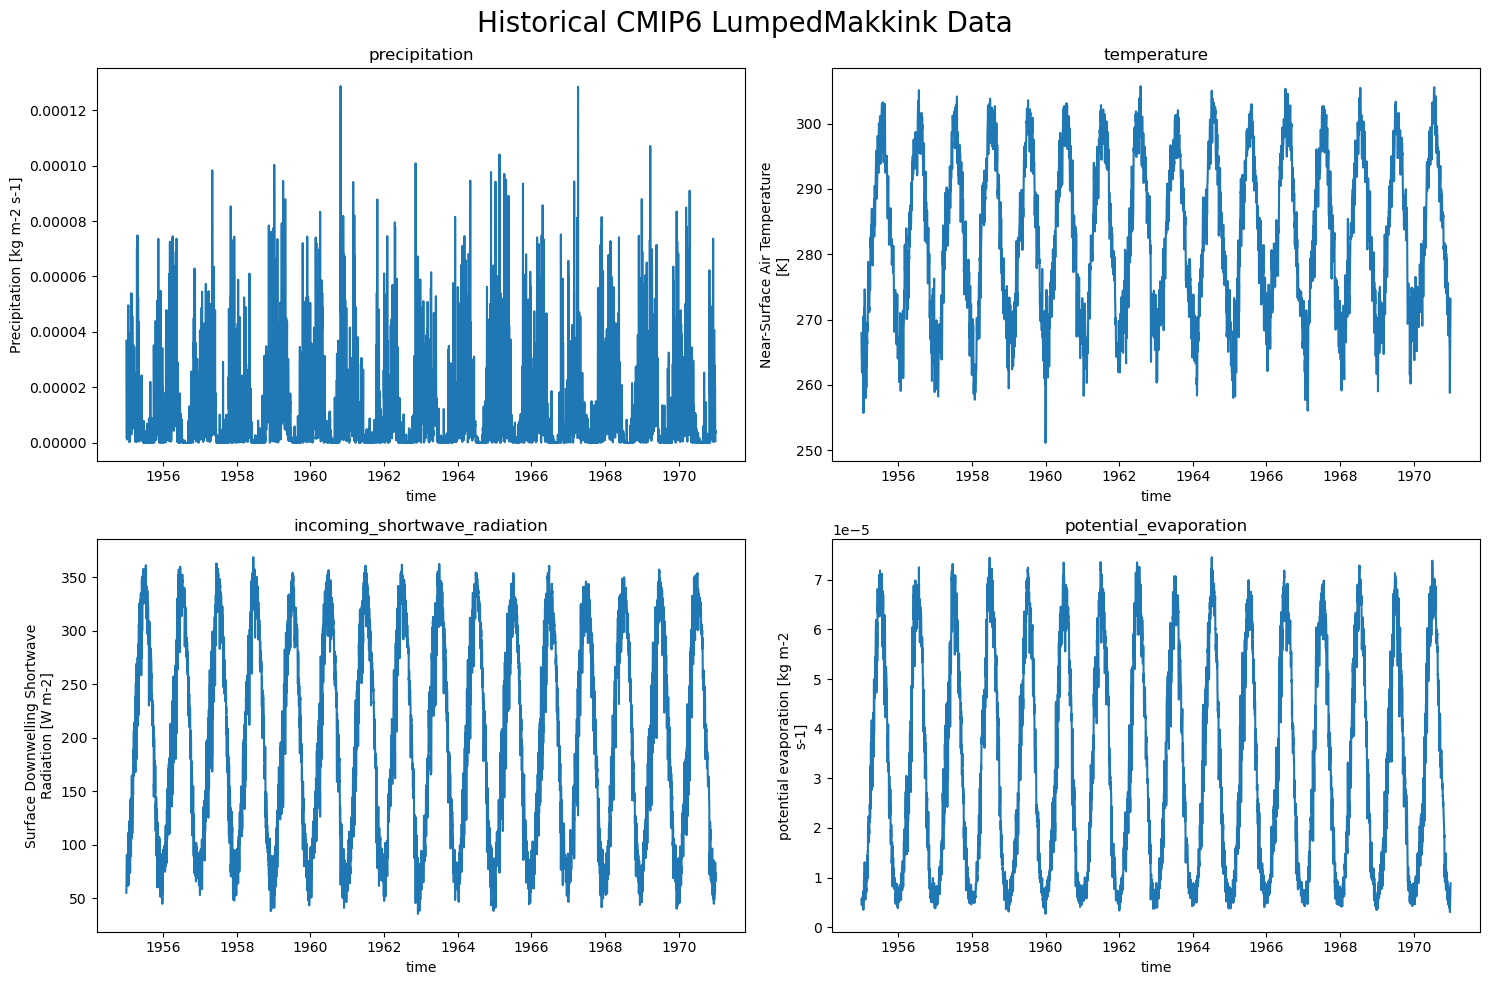

In [14]:
historical_data = {'precipitation pr': xr.open_dataset(historical_CMIP_forcing['pr']),
             'temperature tas': xr.open_dataset(historical_CMIP_forcing['tas']),
             'incoming_shortwave_radiation rsds': xr.open_dataset(historical_CMIP_forcing['rsds']),
             'potential_evaporation evspsblpot': xr.open_dataset(historical_CMIP_forcing['evspsblpot'])
}

plot_counter = 1
plt.figure(figsize=(15, 10))
for name, data in historical_data.items():
    plt.subplot(2,2, plot_counter)
    data[name.split(" ")[-1]].plot()
    plt.title(f"{name.split(" ")[0]}")
    plot_counter += 1

plt.suptitle("Historical CMIP6 LumpedMakkink Data", fontsize=20)
plt.tight_layout()

In [15]:
esmvaltool_padding = 2

pcrglobwb_forcing = ewatercycle.forcing.sources["PCRGlobWBForcing"].generate(
    dataset= cmip_historical,
    start_time=experiment_start_date,
    end_time=experiment_end_date,
    start_time_climatology=experiment_start_date,
    end_time_climatology=experiment_end_date,
    shape=shapefile_path,
    extract_region={
    "start_longitude": 53-esmvaltool_padding,
    "end_longitude": 80+esmvaltool_padding,
    "start_latitude": 34-esmvaltool_padding,
    "end_latitude": 52+esmvaltool_padding,},
    directory = forcing_path_CMIP / "historic" / "PCRGlobWB"

)



In [16]:
print(ewatercycle.forcing.sources)





ForcingSources[
    "CaravanForcing",
    "DistributedMakkinkForcing",
    "DistributedUserForcing",
    "GenericDistributedForcing",
    "GenericLumpedForcing",
    "HypeForcing",
    "LisfloodForcing",
    "LumpedMakkinkForcing",
    "LumpedUserForcing",
    "MarrmotForcing",
    "PCRGlobWBForcing",
    "WflowForcing",
    "WflowJlForcing",
]

In [17]:
from inspect import getsource
print(getsource(ewatercycle.forcing.sources.PCRGlobWBForcing))

class PCRGlobWBForcing(DefaultForcing):
    """Container for PCR-GLOBWB forcing data.

    Args:
        directory: Directory where forcing data files are stored.
        start_time: Start time of forcing in UTC and ISO format string e.g.
            'YYYY-MM-DDTHH:MM:SSZ'.
        end_time: End time of forcing in UTC and ISO format string e.g.
            'YYYY-MM-DDTHH:MM:SSZ'.
        shape: Path to a shape file. Used for spatial selection.
        precipitationNC (optional): Input file for precipitation data. Defaults to
            'precipitation.nc'.
        temperatureNC (optional): Input file for temperature data. Defaults to
            'temperature.nc'

    Example:

        To generate forcing from ERA5 for the Rhine catchment for 2000-2001:

        .. code-block:: python

            from pathlib import Path

            from rich import print

            from ewatercycle_pcrglobwb.forcing import PCRGlobWBForcing

            shape = Path("./src/ewatercycle/testing/data/Rhine/Rhine.shp")

            forcing = PCRGlobWBForcing.generate(
                dataset='ERA5',
                start_time='2000-01-01T00:00:00Z',
                end_time='2001-01-01T00:00:00Z',
                shape=shape.absolute(),
                start_time_climatology='2000-01-01T00:00:00Z',
                end_time_climatology='2001-01-01T00:00:00Z',
            )
            print(forcing)

        Gives something like:

        .. code-block:: python

            PCRGlobWBForcing(
                model='pcrglobwb',
                start_time='2000-01-01T00:00:00Z',
                end_time='2001-01-01T00:00:00Z',
                directory=PosixPath('/home/verhoes/git/eWaterCycle/ewatercycle/esmvaltool_output/ewcrephogjj0pt_202
30816_095928/work/diagnostic/script'),
                shape=PosixPath('/home/verhoes/git/eWaterCycle/ewatercycle/src/ewatercycle/testing/data/Rhine/Rhine
.shp'),
                precipitationNC='pcrglobwb_OBS6_ERA5_reanaly_*_day_pr_2000-2001_Rhine.nc',
                temperatureNC='pcrglobwb_OBS6_ERA5_reanaly_*_day_tas_2000-2001_Rhine.nc'
            )
    """

    precipitationNC: Optional = "precipitation.nc"
    temperatureNC: Optional = "temperature.nc"

    @classmethod
    def generate(  # type: ignore
        cls,
        dataset: str | Dataset | dict,
        start_time: str,
        end_time: str,
        shape: str,
        start_time_climatology: str,  # TODO make optional, default to start_time
        end_time_climatology: str,  # TODO make optional, defaults to start_time + 1 y
        extract_region: Optional = None,
        directory: Optional = None,
    ) -> "PCRGlobWBForcing":
        """Generate forcings for a model.

        The forcing is generated with help of
        `ESMValTool <https://esmvaltool.org/>`_.

        Args:
            dataset: Dataset to get forcing data from.
                When string is given a predefined dataset is looked up in
                :py:const:`ewatercycle.esmvaltool.datasets.DATASETS`.
                When dict given it is passed to
                :py:class:`ewatercycle.esmvaltool.models.Dataset` constructor.
            start_time: Start time of forcing in UTC and ISO format string e.g.
                'YYYY-MM-DDTHH:MM:SSZ'.
            end_time: nd time of forcing in UTC and ISO format string e.g.
                'YYYY-MM-DDTHH:MM:SSZ'.
            shape: Path to a shape file. Used for spatial selection.
            directory:  Directory in which forcing should be written.
                If not given will create timestamped directory.
            start_time_climatology: Start time for the climatology data
            end_time_climatology: End time for the climatology data
            extract_region: Region specification, dictionary must
                contain `start_longitude`, `end_longitude`, `start_latitude`,
                `end_latitude`
        """
        # method is replicated here to document the model specific options
        return super(

In [18]:
#ds_1 = xr.load_dataset('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/forcing_CMIP_3060/AralSeaBasin/CMIP6/future/PCRGlobWB/work/diagnostic/script/pcrglobwb_CMIP6_EC-Earth3_day_ssp585_r1i1p1f1_tas_gr_2030-2060_AralSeaBasin.nc')
#/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Comparison/forcing_CMIP_7071/AralSeaBasin/CMIP6/future/PCRGlobWB/work/diagnostic/script

In [19]:
# # get the first variable name
# first_var = list(ds_1.data_vars)[0]

# # select that variable and last timestep
# da_1 = ds_1[first_var].isel(time=-1)


# #da_1 = ds_1[0].isel(time =-1)


# da_1.plot(cmap="coolwarm", robust=True, size=5)

# #plt.title(str(da["valid_time"].values))  # extract timestamp from coords
# #plt.savefig('ERA5_pr_1988-12-22_21UTC.png')
# plt.show()

<xarray.Dataset> Size: 20MB
Dimensions:    (time: 6209, lat: 24, lon: 33, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 50kB 1954-01-01 1954-01-02 ... 1970-12-31
  * lat        (lat) float32 96B 53.77 52.83 51.9 50.96 ... 34.13 33.2 32.26
  * lon        (lon) float32 132B 51.56 52.5 53.44 54.38 ... 79.69 80.63 81.56
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 20MB 262.2 261.6 261.2 ... 253.5 255.1
    time_bnds  (time, bnds) datetime64[ns] 99kB 1953-12-31T12:00:00 ... 1970-...
    lat_bnds   (lat, bnds) float32 192B 54.23 53.3 53.3 ... 32.73 32.73 31.79
    lon_bnds   (lon, bnds) float32 264B 51.09 52.03 52.03 ... 81.09 81.09 82.03
Attributes: (12/46)
    Conventions:            CF-1.7
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.5.0
    ...                     ...
    table_id:               day
    table_info:             Creation Date:(09 May 2019) MD5:e6ef8ececc8f33864...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    caption:                Forcings for the PCR-GLOBWB hydrological model.

------------------------

<xarray.Dataset> Size: 20MB
Dimensions:    (time: 6209, lat: 24, lon: 33, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 50kB 1954-01-01 1954-01-02 ... 1970-12-31
  * lat        (lat) float32 96B 53.77 52.83 51.9 50.96 ... 34.13 33.2 32.26
  * lon        (lon) float32 132B 51.56 52.5 53.44 54.38 ... 79.69 80.63 81.56
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 20MB 0.001689 0.001481 ... 1.052e-05
    time_bnds  (time, bnds) datetime64[ns] 99kB 1953-12-31T12:00:00 ... 1970-...
    lat_bnds   (lat, bnds) float32 192B 54.23 53.3 53.3 ... 32.73 32.73 31.79
    lon_bnds   (lon, bnds) float32 264B 51.09 52.03 52.03 ... 81.09 81.09 82.03
Attributes: (12/46)
    Conventions:            CF-1.7
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.5.0
    ...                     ...
    table_id:               day
    table_info:             Creation Date:(09 May 2019) MD5:e6ef8ececc8f33864...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            pr
    variant_label:          r1i1p1f1
    caption:                Forcings for the PCR-GLOBWB hydrological model.

------------------------

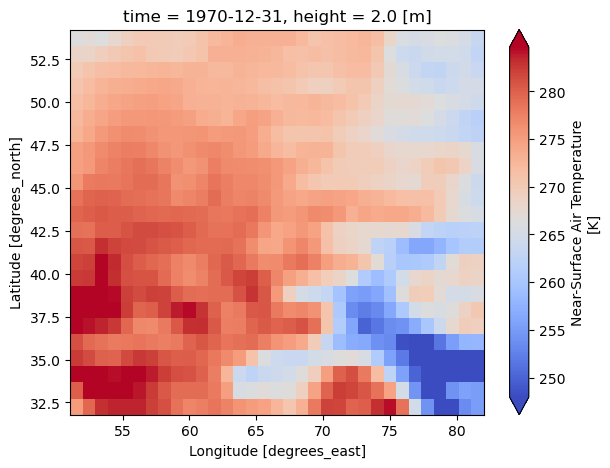

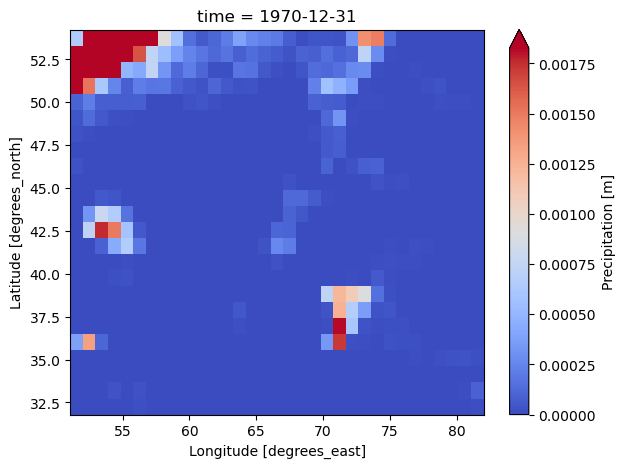

In [20]:
for file_name in [pcrglobwb_forcing.temperatureNC, pcrglobwb_forcing.precipitationNC]:
    dataset = xr.load_dataset(f"{pcrglobwb_forcing.directory}/{file_name}")
    print(dataset)
    print("------------------------")
    var = list(dataset.data_vars.keys())[0]
    dataset[var].isel(time=-1).plot(cmap="coolwarm", robust=True, size=5)

In [21]:
ERA5_forcing = ewatercycle.forcing.sources["PCRGlobWBForcing"].load(
    directory="/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/forcing_1010/AralSeaBasin/pcrglobwb/work/diagnostic/script",
)
print(ERA5_forcing)

PCRGlobWBForcing(
    start_time='2010-09-01T00:00:00Z',
    end_time='2010-12-31T00:00:00Z',
    directory=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in
_progress/Test_Aral/forcing_1010/AralSeaBasin/pcrglobwb/work/diagnostic/script'),
    shape=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_pro
gress/Test_Aral/forcing_1010/AralSeaBasin/pcrglobwb/work/diagnostic/script/AralSeaBasin.shp'),
    filenames={},
    precipitationNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_pr_2010-2010_AralSeaBasin.nc',
    temperatureNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_tas_2010-2010_AralSeaBasin.nc'
)

In [22]:

# import xesmf as xe

# def regrid_to_target(src_file, tgt_file, out_file, method="bilinear"):
#     # load source and target datasets
#     src = xr.load_dataset(src_file)
#     tgt = xr.load_dataset(tgt_file)

#     # choose only variables with lat/lon grid
#     vars_to_regrid = [v for v in src.data_vars if {"lat", "lon"} <= set(src[v].dims)]

#     # create regridder
#     regridder = xe.Regridder(src, tgt, method, extrap_method="nearest_s2d", reuse_weights=False)

#     # regrid all selected variables
#     out_vars = {v: regridder(src[v]) for v in vars_to_regrid}
#     for v in out_vars:
#         out_vars[v].attrs.update(src[v].attrs)

#     # new dataset: use target grid but your regridded variables
#     out = xr.Dataset(out_vars, coords=tgt.coords, attrs=src.attrs)
#     out.to_netcdf(out_file)
#     return out

# # --- regrid temperature ---
# temp_file = f"{pcrglobwb_forcing.directory}/{pcrglobwb_forcing.temperatureNC}"
# temp_tgt  = f"{ERA5_forcing.directory}/{ERA5_forcing.temperatureNC}"
# regrid_to_target(temp_file, temp_tgt, temp_file)

# # --- regrid precipitation ---
# prec_file = f"{pcrglobwb_forcing.directory}/{pcrglobwb_forcing.precipitationNC}"
# prec_tgt  = f"{ERA5_forcing.directory}/{ERA5_forcing.precipitationNC}"
# regrid_to_target(prec_file, prec_tgt, prec_file)

# # --- quick check ---
# for file_name in [pcrglobwb_forcing.temperatureNC, pcrglobwb_forcing.precipitationNC]:
#     ds = xr.load_dataset(f"{pcrglobwb_forcing.directory}/{file_name}")
#     print(ds)
#     print("------------------------")
#     var = list(ds.data_vars.keys())[0]
#     ds[var].isel(time=-1).plot(cmap="coolwarm", robust=True, size=5)


In [23]:
import xesmf as xe

# load your source and target datasets
precipitation_dataset = xr.load_dataset(
    f"{pcrglobwb_forcing.directory}/{pcrglobwb_forcing.precipitationNC}"
)
precipitation_target = xr.load_dataset(
    f"{ERA5_forcing.directory}/{ERA5_forcing.precipitationNC}"
)

# load your source and target datasets
temperature_dataset = xr.load_dataset(
    f"{pcrglobwb_forcing.directory}/{pcrglobwb_forcing.temperatureNC}"
)
temperature_target = xr.load_dataset(
    f"{ERA5_forcing.directory}/{ERA5_forcing.temperatureNC}"
)






# create a regridder (bilinear interpolation here, change method if needed)
regridder_pr = xe.Regridder(
    precipitation_dataset, 
    precipitation_target, 
    "bilinear",
    extrap_method="nearest_s2d"   # or "nearest_d2s", "inverse_dist"
)

# create a regridder (bilinear interpolation here, change method if needed)
regridder_tas = xe.Regridder(
    temperature_dataset, 
    temperature_target, 
    "bilinear",
    extrap_method="nearest_s2d"   # or "nearest_d2s", "inverse_dist"
)



# apply regridding
precipitation_regridded = regridder_pr(precipitation_dataset)
temperature_regridded = regridder_tas(temperature_dataset) 


# save result
precipitation_regridded.to_netcdf(
    f"{pcrglobwb_forcing.directory}/{pcrglobwb_forcing.precipitationNC}"
)

temperature_regridded.to_netcdf(
    f"{pcrglobwb_forcing.directory}/{pcrglobwb_forcing.temperatureNC}"
)

In [24]:
print(pcrglobwb_forcing)

PCRGlobWBForcing(
    start_time='1955-01-01T00:00:00Z',
    end_time='1970-12-31T00:00:00Z',
    directory=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in
_progress/Comparison/forcing_CMIP_5570/AralSeaBasin/CMIP6/historic/PCRGlobWB/work/diagnostic/script'),
    shape=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_pro
gress/Test_Aral/AralSea_Basin/AralSeaBasin.shp'),
    filenames={},
    precipitationNC='pcrglobwb_CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_pr_gn_1955-1970_AralSeaBasin.nc',
    temperatureNC='pcrglobwb_CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_tas_gn_1955-1970_AralSeaBasin.nc'
)

<xarray.Dataset> Size: 276MB
Dimensions:  (time: 6209, lat: 89, lon: 125)
Coordinates:
  * time     (time) datetime64[ns] 50kB 1954-01-01 1954-01-02 ... 1970-12-31
  * lat      (lat) float32 356B 54.0 53.75 53.5 53.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 500B 51.0 51.25 51.5 51.75 ... 81.25 81.5 81.75 82.0
Data variables:
    pr       (time, lat, lon) float32 276MB 0.001689 0.001689 ... 1.052e-05
Attributes:
    regrid_method:  bilinear

------------------------

<xarray.Dataset> Size: 276MB
Dimensions:  (time: 6209, lat: 89, lon: 125)
Coordinates:
  * time     (time) datetime64[ns] 50kB 1954-01-01 1954-01-02 ... 1970-12-31
    height   float64 8B 2.0
  * lat      (lat) float32 356B 54.0 53.75 53.5 53.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 500B 51.0 51.25 51.5 51.75 ... 81.25 81.5 81.75 82.0
Data variables:
    tas      (time, lat, lon) float32 276MB 262.2 262.2 262.2 ... 255.1 255.1
Attributes:
    regrid_method:  bilinear

------------------------

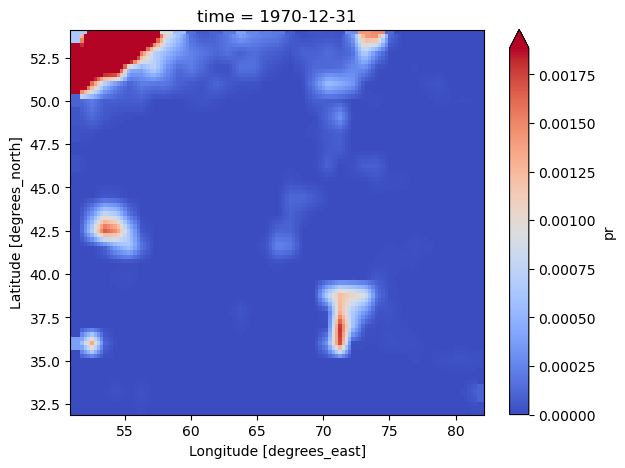

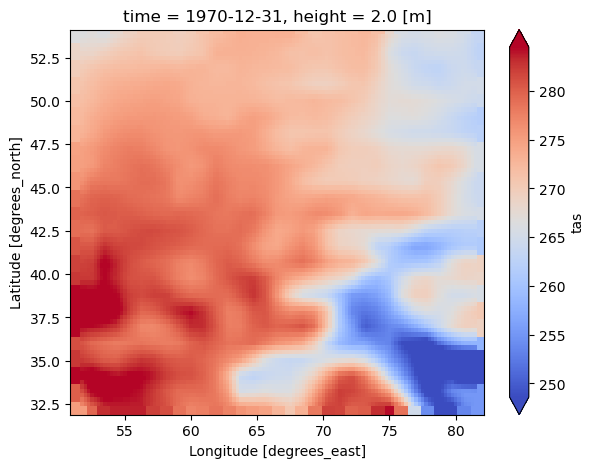

In [25]:
for file_name in [pcrglobwb_forcing.precipitationNC, pcrglobwb_forcing.temperatureNC]:
    dataset = xr.load_dataset(f"{pcrglobwb_forcing.directory}/{file_name}")
    print(dataset)
    print("------------------------")
    var = list(dataset.data_vars.keys())[0]
    dataset[var].isel(time=-1).plot(cmap="coolwarm", robust=True, size=5)

In [26]:
ds_3 = xr.load_dataset("/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/forcing_CMIP_3060/AralSeaBasin/CMIP6/future/PCRGlobWB/work/diagnostic/script/pcrglobwb_CMIP6_EC-Earth3_day_ssp585_r1i1p1f1_pr_gr_2030-2060_AralSeaBasin.nc")

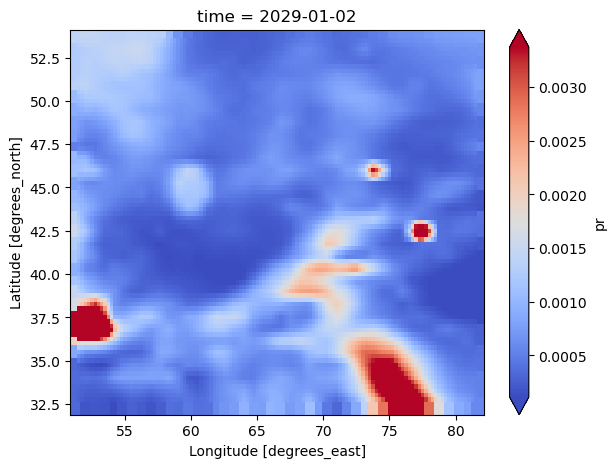

In [27]:
# get the first variable name
first_var = list(ds_3.data_vars)[0]

# select that variable and last timestep
da_3 = ds_3[first_var].isel(time=1)


#da_1 = ds_1[0].isel(time =-1)


da_3.plot(cmap="coolwarm", robust=True, size=5)

#plt.title(str(da["valid_time"].values))  # extract timestamp from coords
#plt.savefig('ERA5_pr_1988-12-22_21UTC.png')
plt.show()

In [28]:
ewatercycle.esmvaltool.search.search_esgf

<function ewatercycle.esmvaltool.search.search_esgf(experiment: str, frequency: Literal['hr', '3hr', 'day'], variables: list[str], project: str = 'CMIP6', extended_mip_tables: bool = False, verbose: bool = False) -> dict[str, set[str]]>

In [30]:
# from ewatercycle.esmvaltool.search import search_esgf
# valid_datasets = search_esgf(
#     experiment="historical",
#     frequency="day",
#     variables=["pr", "tas",]
#)

In [31]:
# print(valid_datasets)